# Libraries

In [27]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
from keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [28]:
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

# Data

## Data Path

In [29]:
base_dir = r'C:\Users\user\Documents\Datasets\Fruits Vegetables'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

## Count Data and Classes

In [30]:
def num_of_classes(folder_dir, folder_name):
    classes = [class_name for class_name in os.listdir(train_dir)]
    print(colored(f'number of classes in {folder_name} folder : {len(classes)}', 'blue', attrs=['bold']))
    
num_of_classes(train_dir, 'train')
num_of_classes(validation_dir, 'validation')
num_of_classes(test_dir, 'test')

number of classes in train folder : 36
number of classes in validation folder : 36
number of classes in test folder : 36


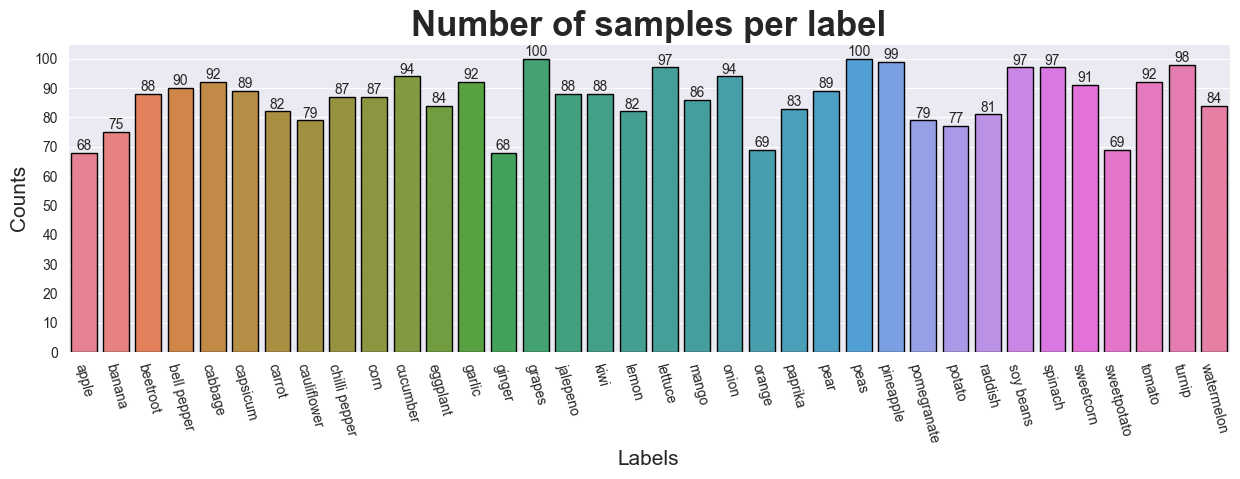

In [31]:
classes  = [class_name for class_name in os.listdir(train_dir)]
count = []

for class_name in classes:
    count.append(len(os.listdir(os.path.join(train_dir, class_name))))
    
plt.figure(figsize=(15, 4))
ax = sns.barplot(x = classes, y = count, hue = classes, edgecolor = 'black')
plt.xticks(rotation = 285)
for i in ax.containers:
    ax.bar_label(i, )
plt.title('Number of samples per label', fontsize = 25, fontweight = 'bold')
plt.xlabel('Labels', fontsize = 15)
plt.ylabel('Counts', fontsize = 15)
plt.yticks(np.arange(0, 105, 10))
plt.show()

## Converting Data into DataFrame

In [32]:
def create_df(folder_path):
    all_images = []
    for class_name in classes:
        class_path = os.path.join(folder_path, class_name)
        all_images.extend([(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)])
    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df

In [33]:
train_df = create_df(train_dir)
validation_df = create_df(validation_dir)
test_df = create_df(test_dir)

In [34]:
print(colored(f'Number of samples in train: {len(train_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples in validation: {len(validation_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples in test: {len(test_df)}', 'blue', attrs=['bold']))

Number of samples in train: 3115
Number of samples in validation: 351
Number of samples in test: 359


## Show an Images per each class label

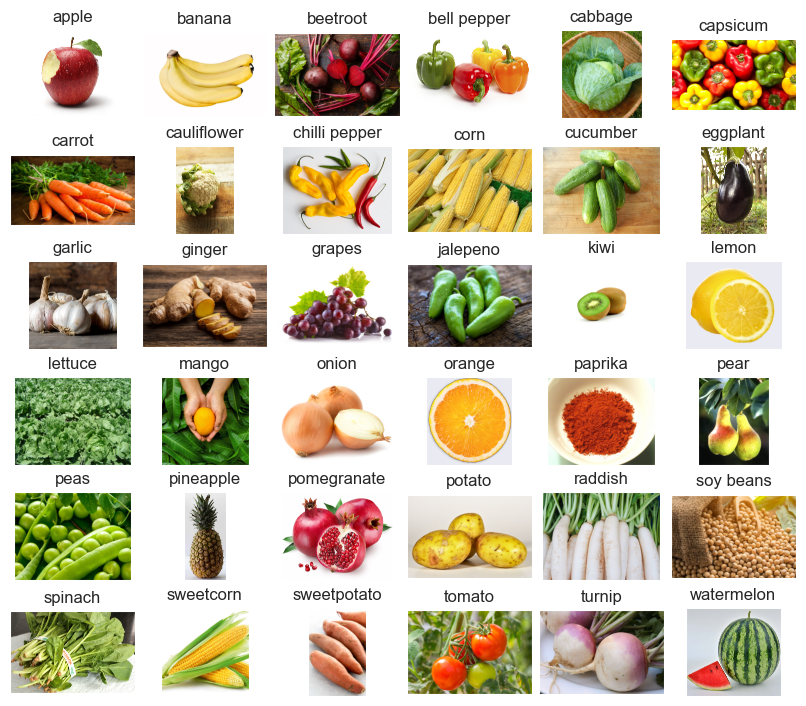

In [44]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=['label']).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows = 6, ncols = 6, figsize = (8, 7),
                         subplot_kw = {'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.file_path[i]))
    ax.set_title(df_unique.label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

## Data Generators

In [49]:
# Train generator
train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Scaled images in range 0 to 1
    rotation_range=20,              # Rorate images by factor 20 degree
    width_shift_range=0.2,          # Shift images horizontally by up to 20% of their width
    height_shift_range=0.2,         # Shift images vertically by up to 20% of their width
    zoom_range=0.1,                 # Zoom in and out images by 10%
    horizontal_flip=True,           # Allow horizontal flipping
    shear_range=0.1,                # shear images by 10% their size
    fill_mode='nearest',            # fill unlocated pixels by nearest pixel
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,           # Target data
    x_col = 'file_path',            # X column
    y_col = 'label',                # y column
    target_size = (224, 224),       # Resizes image to 224 x 224
    color_mode = 'rgb',             # Color mode
    class_mode = 'categorical',     # Type of model
    batch_size = 32,
    shuffle = True,
    seed = 42
)

Found 3115 validated image filenames belonging to 36 classes.


In [51]:
# Validation generator

validation_datagen = ImageDataGenerator(rescale=1./255,)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe = validation_df,
    x_col = 'file_path',
    y_col = 'label',
    target_size = (224, 224),
    class_mode = 'categorical',
    batch_size = 32,
    seed = 42,
    shuffle = False
)

Found 351 validated image filenames belonging to 36 classes.


In [52]:
# Test generator

test_datagen = ImageDataGenerator(rescale=1. / 255,)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'file_path',
    y_col = 'label',
    target_size = (224, 224),
    class_mode = 'categorical',
    batch_size = 32,
    seed = 42,
    shuffle = False
)

Found 359 validated image filenames belonging to 36 classes.


# Modeling

In [53]:
pre_trained_model = MobileNetV2(
    input_shape = (224, 224, 3),    # Input image size
    include_top = False,            # Model not include top layer
    weights = 'imagenet',           # Weights type 
    pooling = 'avg'                 # Type of pooling layer
)

9406464/9406464 [==============================] - 3s 0us/step


Name of layers in MobileNetV2

In [54]:
for layer in pre_trained_model.layers:
    print(layer.name)

input_1
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand
block_6_expand

In [55]:
# Freeze all layers except the last one, the goal is to train only the last layer of pre trained model

pre_trained_model.trainable = True
set_trainable = False

for layer in pre_trained_model.layers:
    if layer.name == 'block_16_expand':
        set_trainable = True
    if set_trainable: 
        layer.trainable = True
    else:
        layer.trainable = False

## Define model

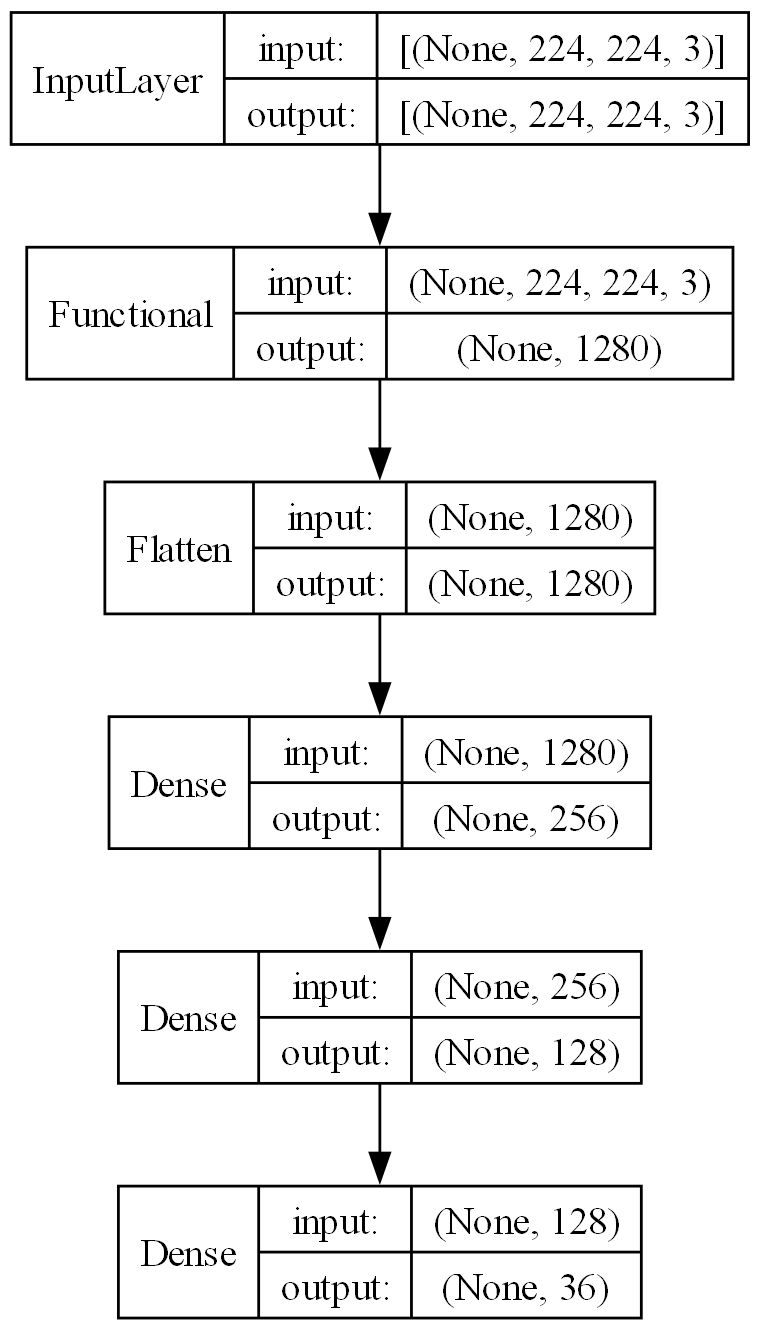

In [58]:
model = models.Sequential()
model.add(pre_trained_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(36, activation = 'softmax'))

plot_model(model, show_shapes = True, show_layer_names=False, dpi = 200)

In [59]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 flatten_2 (Flatten)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               327936    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 36)                4644      
                                                                 
Total params: 2,623,460
Trainable params: 1,251,556
Non-trainable params: 1,371,904
____________________________________

## Compile Model

In [60]:
# Compile
model.compile(optimizer = optimizers.Adam(learning_rate=0.001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

## CallBacks

In [61]:
# Model CheckPoint
checkpoint_cb = ModelCheckpoint('MyModel.keras', save_best_only=True)

# Early Stopping
earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True)

# ReduceLRonPlateau
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 3, min_lr = 1e-6)

## Train Model

In [64]:
history = model.fit(
    train_generator,
    steps_per_epoch = len(train_generator),
    epochs = 50,
    validation_data = validation_generator,
    validation_steps = len(validation_generator),
    callbacks = [checkpoint_cb, earlystop_cb, reduce_lr]
)

Epoch 1/50
98/98 [==============================] - 69s 706ms/step - loss: 0.7418 - accuracy: 0.7689 - val_loss: 1.9640 - val_accuracy: 0.6923 - lr: 0.0010
Epoch 2/50
98/98 [==============================] - 68s 694ms/step - loss: 0.6024 - accuracy: 0.8019 - val_loss: 1.7618 - val_accuracy: 0.6724 - lr: 0.0010
Epoch 3/50
98/98 [==============================] - 69s 699ms/step - loss: 0.4962 - accuracy: 0.8318 - val_loss: 2.9257 - val_accuracy: 0.5897 - lr: 0.0010
Epoch 4/50
98/98 [==============================] - 71s 723ms/step - loss: 0.4561 - accuracy: 0.8465 - val_loss: 1.0380 - val_accuracy: 0.8063 - lr: 0.0010
Epoch 5/50
98/98 [==============================] - 70s 707ms/step - loss: 0.4277 - accuracy: 0.8562 - val_loss: 0.7238 - val_accuracy: 0.8376 - lr: 0.0010
Epoch 6/50
98/98 [==============================] - 70s 711ms/step - loss: 0.3355 - accuracy: 0.8828 - val_loss: 0.9976 - val_accuracy: 0.8291 - lr: 0.0010
Epoch 7/50
98/98 [==============================] - 71s 722ms/st

In [65]:
# Convert resutl of training to a DataFrame
result_df = pd.DataFrame(history.history)
result_df.tail()

loss  accuracy  val_loss  val_accuracy        lr
45  0.020228  0.991332  0.140800      0.965812  0.000063
46  0.022269  0.989085  0.131084      0.971510  0.000063
47  0.023305  0.990690  0.135931      0.971510  0.000063
48  0.019594  0.991653  0.125474      0.974359  0.000063
49  0.020546  0.990369  0.133572      0.968661  0.000063

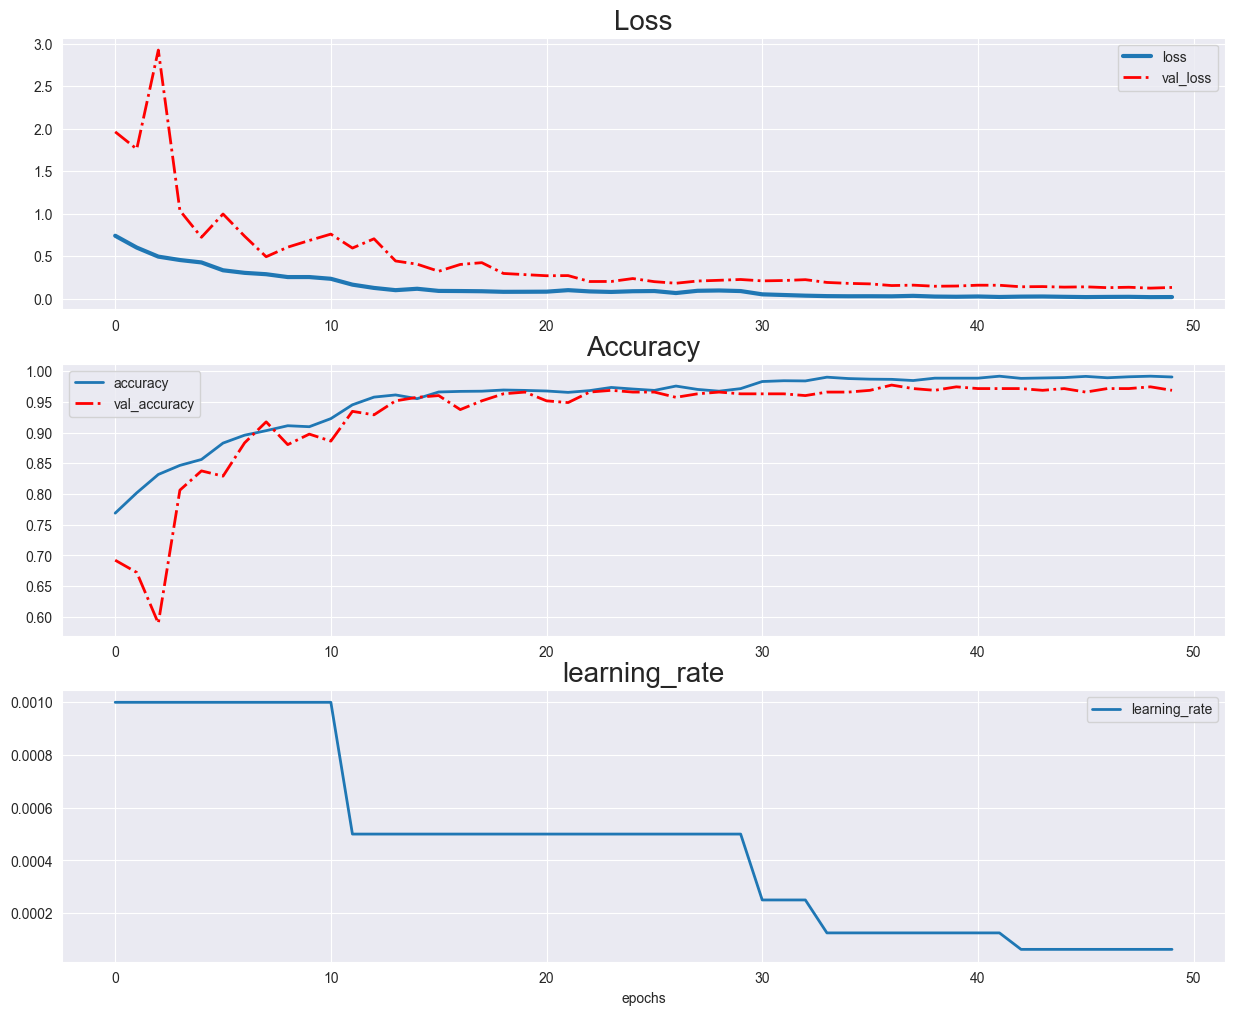

In [66]:
x = np.arange(len(result_df))
fig, ax = plt.subplots(3, 1, figsize=(15, 12))
#  AX0 : Loss
ax[0].plot(x, result_df.loss, label='loss', linewidth=3)
ax[0].plot(x, result_df.val_loss, label='val_loss', linewidth=2, ls='-.', c='r')
ax[0].set_title('Loss', fontsize=20)
ax[0].legend()

#  AX1 : Loss
ax[1].plot(x, result_df.accuracy, label='accuracy', linewidth=2)
ax[1].plot(x, result_df.val_accuracy, label='val_accuracy', linewidth=2, ls='-.', c='r')
ax[1].set_title('Accuracy', fontsize=20)
ax[1].legend()

#  AX2 : Loss
ax[2].plot(x, result_df.lr, label='learning_rate', linewidth=2)
ax[2].set_title('learning_rate', fontsize=20)
ax[2].set_xlabel('epochs')
ax[2].legend()


plt.sharex=True


plt.show()

## Evaluate Model

In [67]:
# checkpoint callback, save base model weights in "MyModel.keras".
# So, we should load it
best_model = models.load_model('MyModel.keras')

In [68]:
test_loss, test_acc = best_model.evaluate_generator(test_generator)

print(colored(f'Test Loss : {round(test_loss, 3)}', 'green', attrs=['bold']))
print(colored(f'Test Accuracy : {round(test_acc, 3)}', 'green', attrs=['bold']))

Test Loss : 0.123
Test Accuracy : 0.975


In [69]:
def evaluate_model_performance(model, val_generator, class_labels):
    """
    Evaluate the model's performance on the validation set and print the classification report.

    Parameters:
    - model: The trained model.
    - val_generator: Validation data generator.
    - class_labels: List of class names.
    
    Returns:
    - report: Classification report as a string.
    """
    
    # Getting all the true labels for the validation set
    true_labels = val_generator.classes

    # Get the class labels (names) from the generator
    class_labels = list(val_generator.class_indices.keys())

    # To get the predicted labels, we predict using the model  
    predictions = model.predict(val_generator, steps=len(val_generator))
    
    # Take the argmax to get the predicted class indices.
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Extracting true labels from the validation generator
    true_labels = val_generator.classes

    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')
    
    # Define a custom colormap
    colors = ["white", "#102C42"]
    # cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plotting confusion matrix using seaborn
    plt.figure(figsize=(15,10))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

11/11 [==============================] - 7s 591ms/step
               precision    recall  f1-score   support

        apple       1.00      0.90      0.95        10
       banana       1.00      0.78      0.88         9
     beetroot       1.00      1.00      1.00        10
  bell pepper       0.82      1.00      0.90         9
      cabbage       1.00      1.00      1.00        10
     capsicum       1.00      0.80      0.89        10
       carrot       1.00      1.00      1.00         9
  cauliflower       1.00      1.00      1.00        10
chilli pepper       1.00      1.00      1.00         9
         corn       0.83      1.00      0.91        10
     cucumber       1.00      1.00      1.00        10
     eggplant       1.00      1.00      1.00        10
       garlic       1.00      1.00      1.00        10
       ginger       1.00      1.00      1.00        10
       grapes       1.00      1.00      1.00         9
     jalepeno       0.90      1.00      0.95         9
         

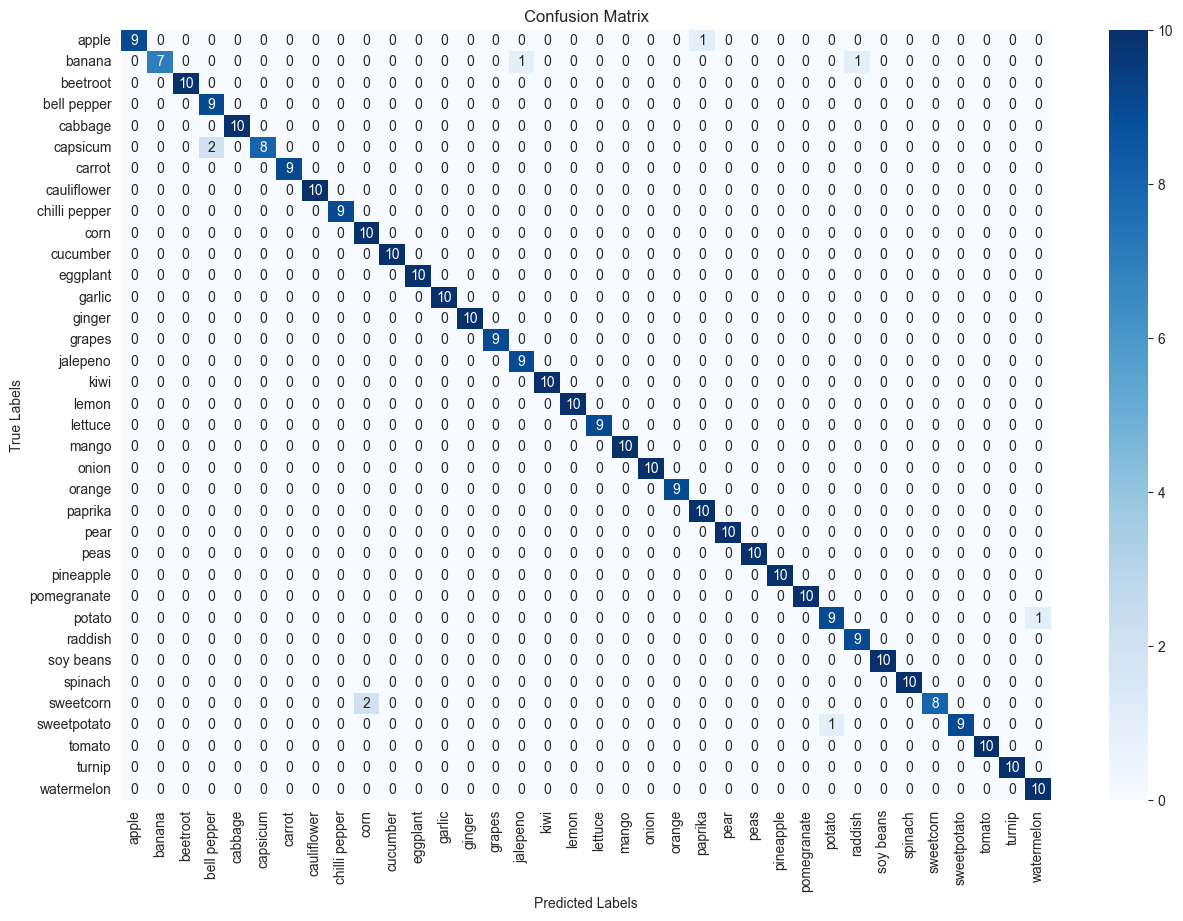

In [70]:
evaluate_model_performance(best_model, validation_generator, classes)

11/11 [==============================] - 7s 625ms/step
               precision    recall  f1-score   support

        apple       1.00      0.80      0.89        10
       banana       1.00      0.78      0.88         9
     beetroot       1.00      1.00      1.00        10
  bell pepper       0.82      1.00      0.90         9
      cabbage       1.00      1.00      1.00        10
     capsicum       1.00      0.80      0.89        10
       carrot       1.00      1.00      1.00         9
  cauliflower       1.00      1.00      1.00        10
chilli pepper       1.00      1.00      1.00         9
         corn       0.82      0.90      0.86        10
     cucumber       1.00      1.00      1.00        10
     eggplant       1.00      1.00      1.00        10
       garlic       1.00      1.00      1.00        10
       ginger       1.00      1.00      1.00        10
       grapes       1.00      1.00      1.00         9
     jalepeno       0.90      1.00      0.95         9
         

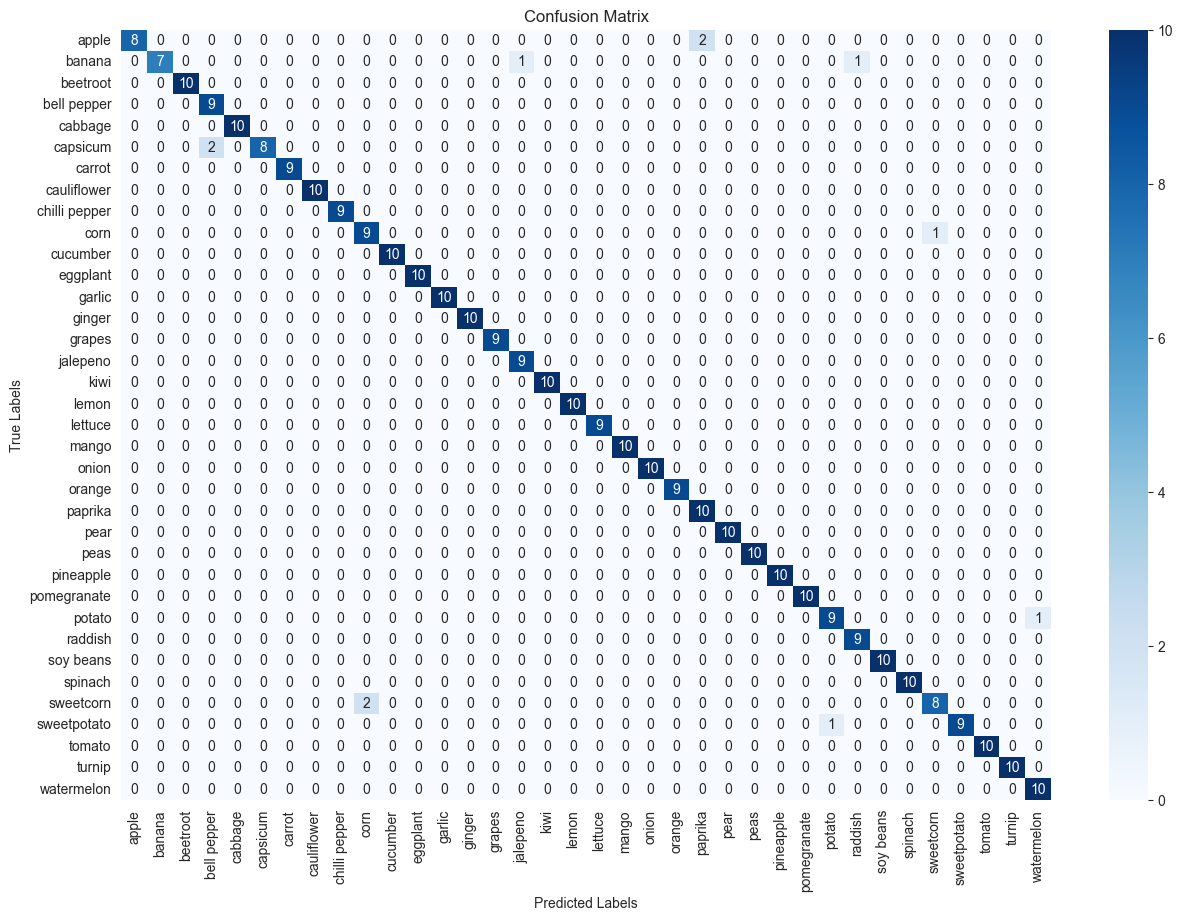

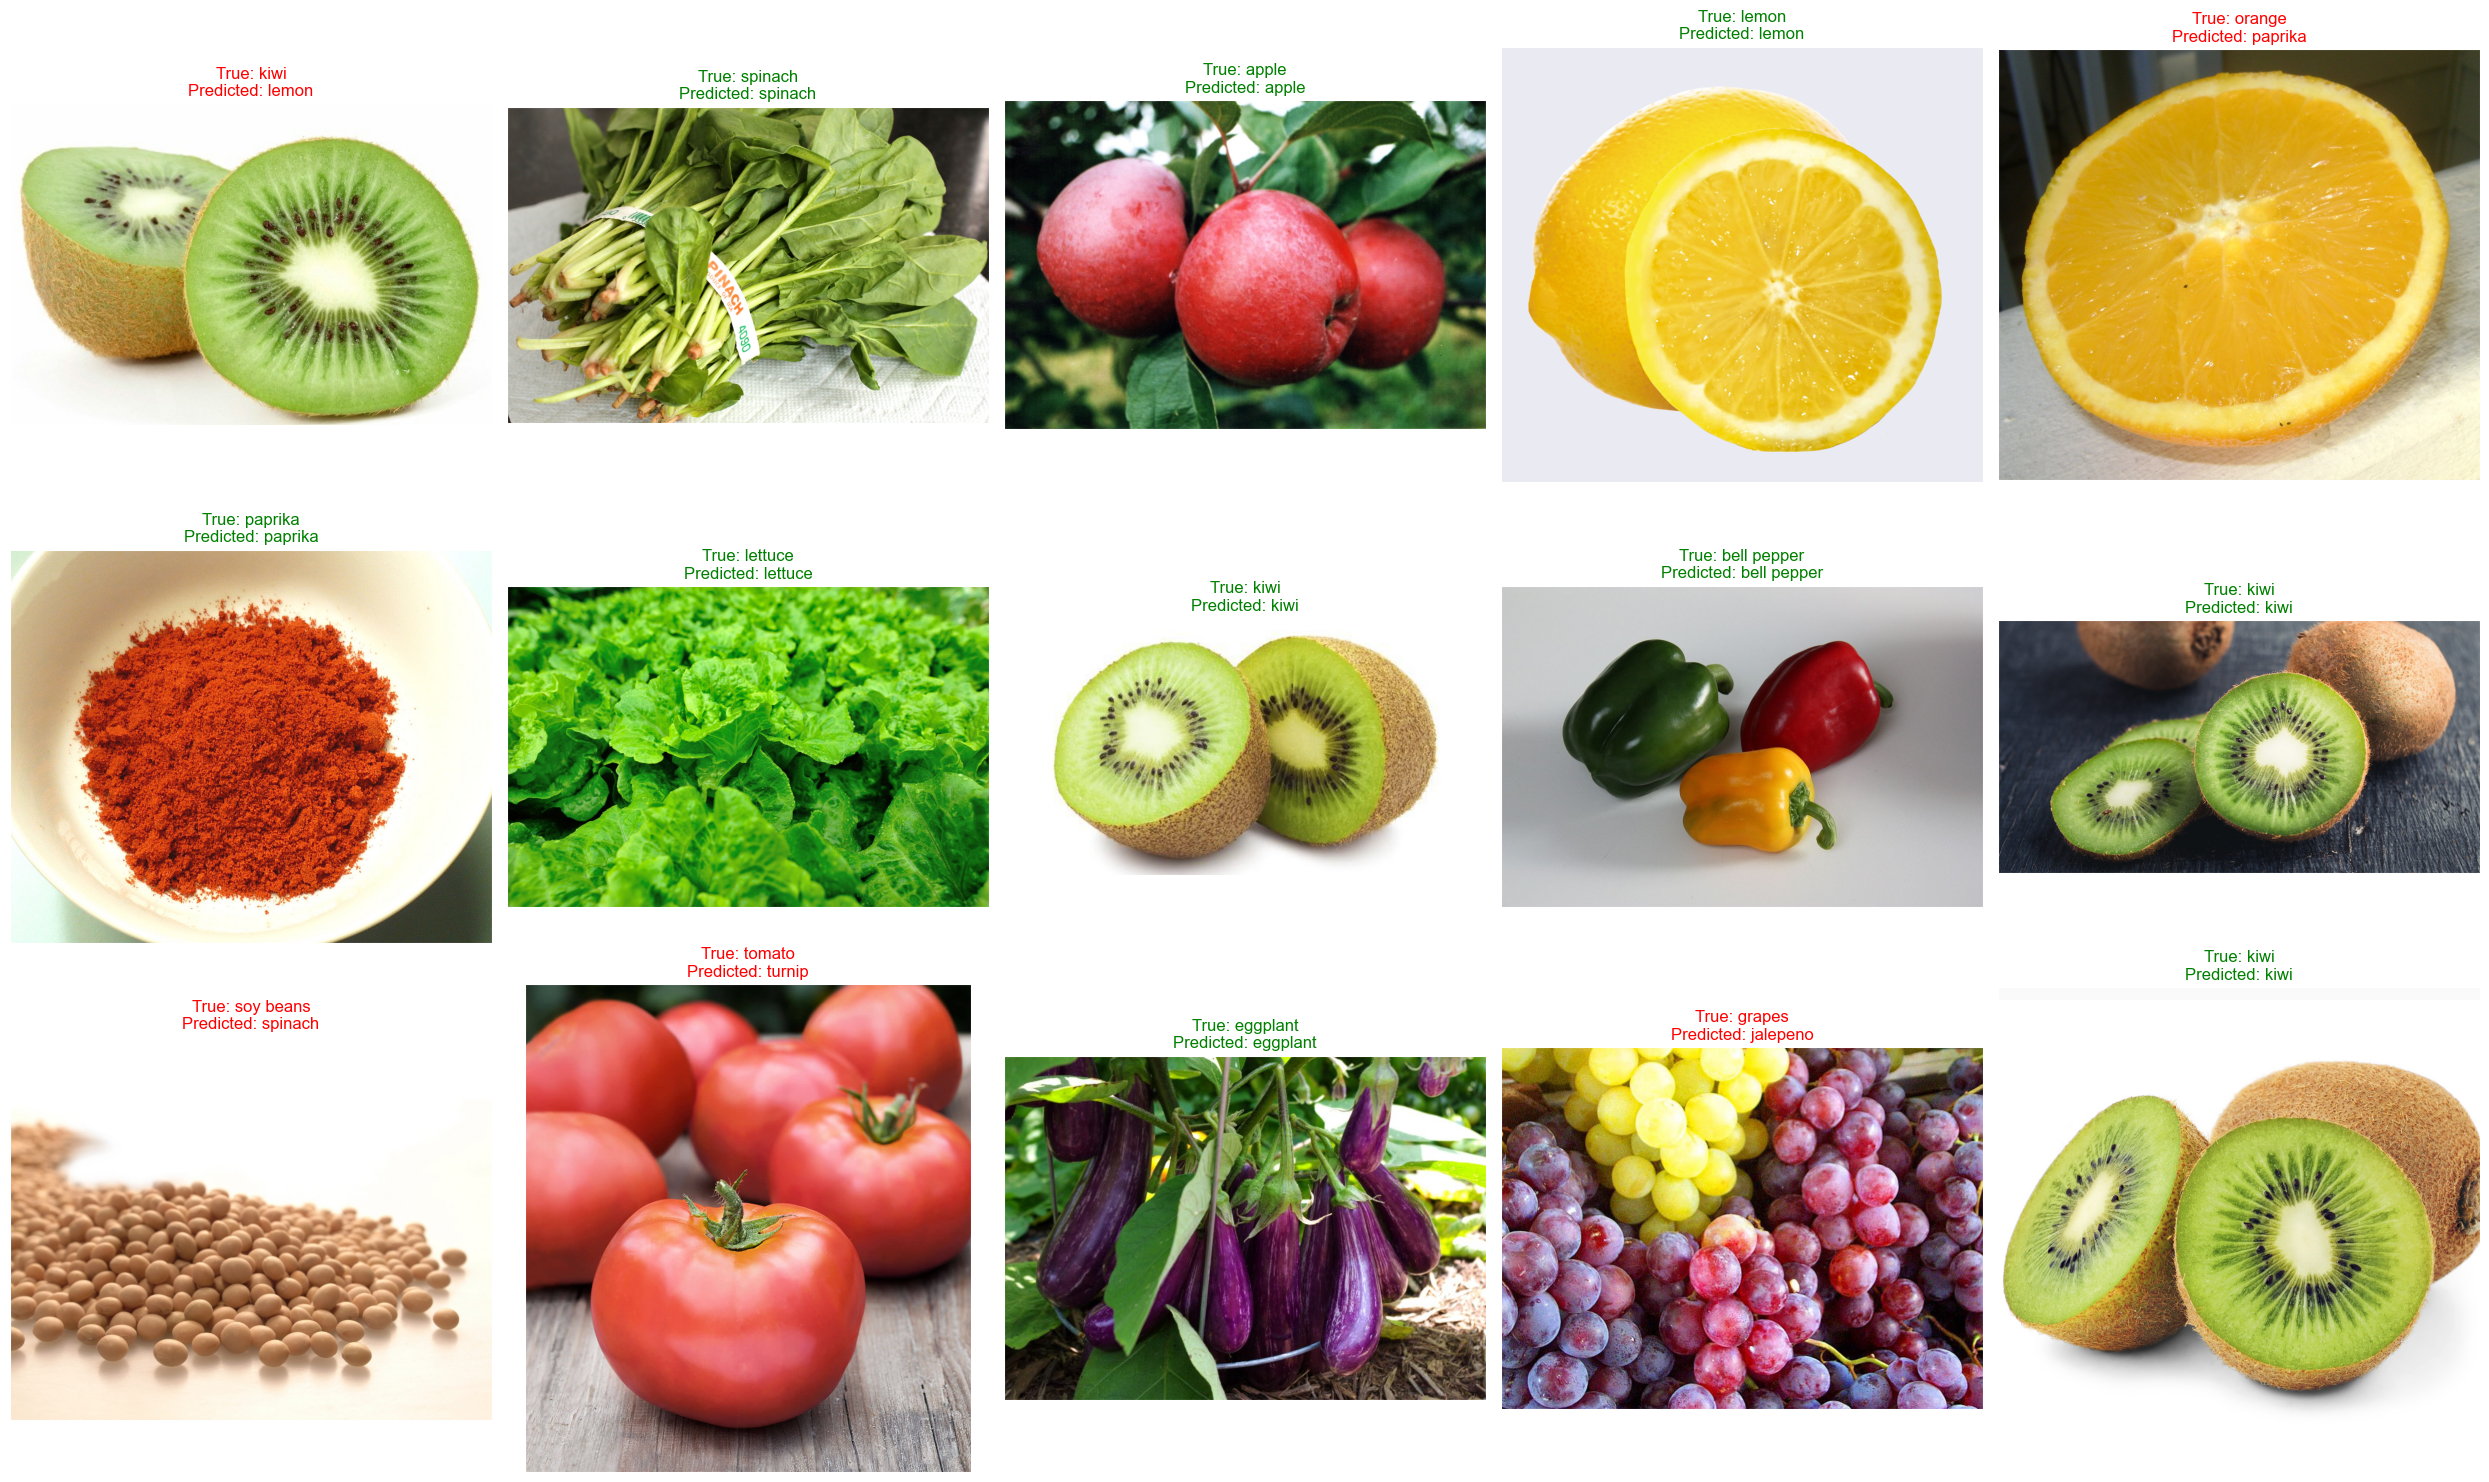

In [88]:
def evaluate_model_performance(model, val_generator, class_labels, test_df, num_images=15):
    """
    Evaluate the model's performance on the validation set, print the classification report,
    display the confusion matrix, and visualize random image predictions.

    Parameters:
    - model: The trained model.
    - val_generator: Validation data generator.
    - class_labels: List of class names.
    - test_df: Test dataframe containing filepaths and labels.
    - num_images: Number of images to display in the plot.
    
    Returns:
    - report: Classification report as a string.
    """
    
    # Getting all the true labels for the validation set
    true_labels = test_generator.classes

    # To get the predicted labels, we predict using the model  
    predictions = model.predict(test_generator, steps=len(test_generator))
    
    # Take the argmax to get the predicted class indices.
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')
    
    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plotting confusion matrix using seaborn
    plt.figure(figsize=(15,10))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Randomly visualize some predictions
    random_index = np.random.randint(0, len(test_df) - 1, num_images)
    fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                             subplot_kw={'xticks': [], 'yticks': []})
    
    for i, ax in enumerate(axes.flat):
        # Replace 'file_path' and 'class_label' with the correct column names for image paths and labels
        img_path = test_df['file_path'].iloc[random_index[i]]
        true_label = test_df['label'].iloc[random_index[i]]
        
        # Get the predicted class index and map it to the class name
        pred_index = predicted_labels[random_index[i]]
        pred_label = class_labels[pred_index]  # Convert the index to the class name

        # Display the image
        ax.imshow(plt.imread(img_path))
        
        # Determine the color of the title based on prediction accuracy
        if true_label == pred_label:
            color = "green"
        else:
            color = "red"
        
        # Set title showing true and predicted class names
        ax.set_title(f"True: {true_label}\nPredicted: {pred_label}", color=color)
    
    plt.tight_layout()
    plt.show()

evaluate_model_performance(model, validation_generator, classes, test_df)

In [81]:
true_label

file_path       label
0    C:\Users\user\Documents\Datasets\Fruits Vegeta...       apple
1    C:\Users\user\Documents\Datasets\Fruits Vegeta...       apple
2    C:\Users\user\Documents\Datasets\Fruits Vegeta...       apple
3    C:\Users\user\Documents\Datasets\Fruits Vegeta...       apple
4    C:\Users\user\Documents\Datasets\Fruits Vegeta...       apple
..                                                 ...         ...
354  C:\Users\user\Documents\Datasets\Fruits Vegeta...  watermelon
355  C:\Users\user\Documents\Datasets\Fruits Vegeta...  watermelon
356  C:\Users\user\Documents\Datasets\Fruits Vegeta...  watermelon
357  C:\Users\user\Documents\Datasets\Fruits Vegeta...  watermelon
358  C:\Users\user\Documents\Datasets\Fruits Vegeta...  watermelon

[359 rows x 2 columns]